# Panorama Project - Yang Benjamin

Le but du projet est d'étudier les notions d'homographie, de RANSAC et autre. Voici le plan en 4 niveaux :

1. Les transformations géométriques
2. Feature Matching
3. RANSAC
4. Image Stitching and Blending

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def im_show(img, title="Result"):
    plt.figure(figsize=(10, 8))
    
    # Cas 1 : Image en niveaux de gris (Matrice 2D)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        
    # Cas 2 : Image couleur (Tenseur 3D)
    else:
        # On passe de BGR (OpenCV) à RGB (Matplotlib)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        
    plt.title(title)
    plt.axis('off')
    plt.show()

## Les transformations géométriques

Étudions dans un premier temps les notions d'homographie et de Warping.

### L'homographie

Imaginons une image sur un tapis déformable.
* Si on zoome, c'est une **homotéthie**
* Si on tourne, c'est une **rotation**
* Si on tire sur un coin et qu'on déforme, c'est une **homographie**

L'homographie ne conserve donc pas nécessairement les angles ni les distances

Afin de pouvoir réaliser cette transformation, on doit passer en **coordonnées homogènes**. 

On ajoute donc une dimension au point (x,y) :
$\begin{pmatrix} x \\ y \\ 1 \end{pmatrix}$.

L'homographie est une matrice $3 \times 3$ notée $H$ :$$\begin{pmatrix} x' \\ y' \\ w' \end{pmatrix} = \begin{pmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}$$

Ainsi, à la fin, on obtient un vecteur w' qui n'est plus égal à 1, de fait, on aura :
$$x_{final} = \frac{x'}{w'} \quad , \quad y_{final} = \frac{y'}{w'}$$

Naturellement, on voudrait coder de l'image source à l'image destination. Mais lors d'une transformation, le caractère discret de l'information contenue dans l'image imposera à cette méthode des trous et des vides. C'est pourquoi il convient d'appliquer l'inverse Mapping.

Lors de cette transformation inverse, la valeur que nous donnera notre matrice H inverse ne sera pas entière. C'est pourquoi nous calculerons une interpolation pour estimer le couleur du point. Cette couleur est donnée par :

$V = (1-dx)(1-dy) \cdot I(x,y) + (dx)(1-dy) \cdot I(x+1,y) + (1-dx)(dy) \cdot I(x,y+1) + (dx)(dy) \cdot I(x+1,y+1)$

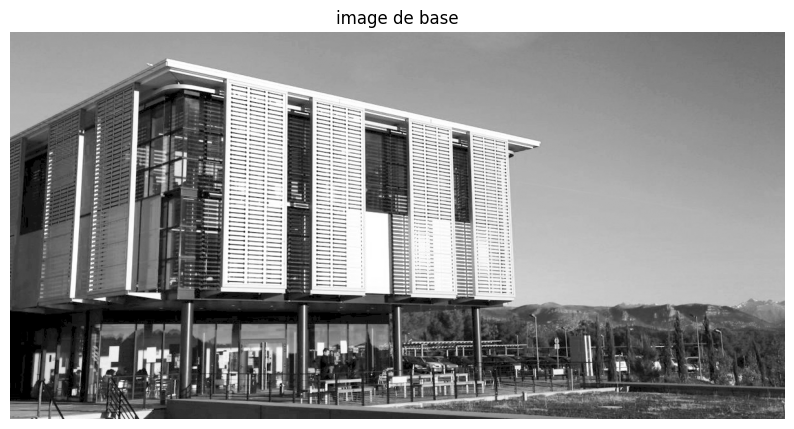

In [45]:
img = cv2.imread("../data/pns_original.png", cv2.IMREAD_GRAYSCALE)
im_show(img, 'image de base')

In [15]:
def warping_pixel(img, x_f, y_f):
    img = img.astype(np.float32)
    x, y = np.floor(x_f).astype(int), np.floor(y_f).astype(int)
    #print(x, y)
    dx, dy = x_f-x, y_f-y

    return (1-dx)*(1-dy)*img[x,y] + dx*(1-dy)*img[x+1, y] + (1-dx)*dy*img[x, y+1] + dx*dy*img[x+1, y+1]

In [16]:
warping_pixel(img, 60.3, 72.3)

np.float64(168.0)

In [61]:
# On définit H (Exemple : une petite rotation + translation)
theta = np.radians(10)
H = np.array([
    [np.cos(theta), -np.sin(theta), 10],
    [np.sin(theta),  np.cos(theta), 20],
    [0,              0,             1]
])

In [62]:
h, w = img.shape #hauteur et largeur de notre image d'arrivée
y_f, x_f = np.indices((h, w))
x_f.flatten() #aplatit toute notre matrice sur le vecteur
n = h*w #taille du vecteur P en coordonnées homogènes (pour vectoriser)
P_dest = np.ones((3, n))
#print(P.shape)
P_dest[:-1, :] = np.array([x_f.flatten(), y_f.flatten()])
P_dest

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 1.197e+03, 1.198e+03,
        1.199e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.990e+02, 5.990e+02,
        5.990e+02],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], shape=(3, 720000))

On crée la matrice de coordonnées $\mathbf{P}_{dest}$ de taille $(3, N)$ où $N = H \times W$ :$$\mathbf{P}_{dest} = \begin{pmatrix} x_1 & x_2 & \cdots & x_n \\ y_1 & y_2 & \cdots & y_n \\ 1 & 1 & \cdots & 1 \end{pmatrix}$$

Puis on cherche d'où viennent ces points dans l'image source en utilisant $H^{-1}$ :$$\mathbf{P}_{src\_h} = H^{-1} \cdot \mathbf{P}_{dest}$$

Cela nous donne des coordonnées homogènes sources $\begin{pmatrix} x'_h \\ y'_h \\ w'_h \end{pmatrix}$. Pour obtenir les positions réelles $(x_f, y_f)$ sur lesquelles notre interpolation va travailler, on divise par $w'_h$ :$$x_f = \frac{x'_h}{w'_h}, \quad y_f = \frac{y'_h}{w'_h}$$

In [63]:
def warping(img, x_arr, y_arr):
    h, w = img.shape
    x0, y0 = np.clip(np.floor(x_arr).astype(int), 0, w-1), np.clip(np.floor(y_arr).astype(int), 0, h-1)
    x1, y1 = np.clip(x0+1, 0, w-1), np.clip(y0+1, 0, h-1)
    dx, dy = x_arr-x0, y_arr-y0
    pixels = (1-dx)*(1-dy)*img[y0,x0] + dx*(1-dy)*img[y0, x1] + (1-dx)*dy*img[y1, x0] + dx*dy*img[y1, x1]
    #pixels = (1-dx)*(1-dy)*img[x0,y0] + dx*(1-dy)*img[x0, y1] + (1-dx)*dy*img[x1, y0] + dx*dy*img[x1, y1]
    return pixels

In [64]:
P_src = np.linalg.inv(H) @ P_dest
x_src = P_src[0] / P_src[2]
y_src = P_src[1] / P_src[2]

On obtient ici les coordonnées de notre image de base, donc on va pouvoir extraire toutes les valeurs avec notre interpolation du dessus :

In [65]:
pixels_final = warping(img, x_src, y_src)
img_final = pixels_final.reshape((h, w))

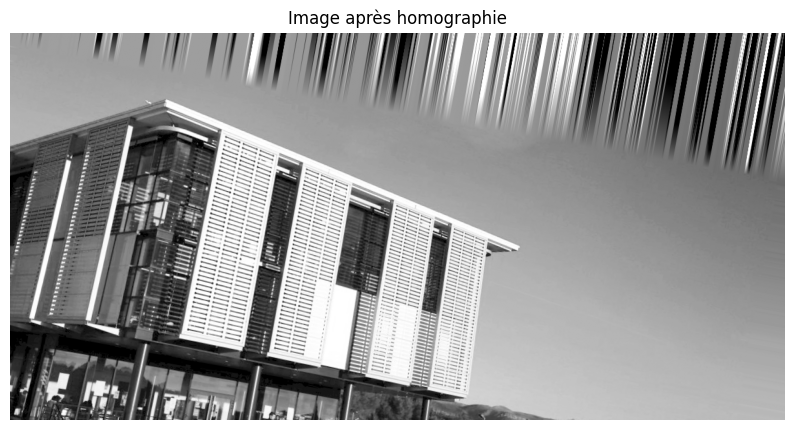

In [66]:
im_show(img_final, "Image après homographie")

In [67]:
def homographie(img, H):
    h, w = img.shape #hauteur et largeur de notre image d'arrivée
    y_f, x_f = np.indices((h, w))
    n = h*w #taille du vecteur P en coordonnées homogènes (pour vectoriser)
    P_dest = np.ones((3, n))
    P_dest[:-1, :] = np.array([x_f.flatten(), y_f.flatten()])

    P_src = np.linalg.inv(H) @ P_dest
    x_src = P_src[0] / P_src[2]
    y_src = P_src[1] / P_src[2]

    pixels_final = warping(img, x_src, y_src)
    img_final = pixels_final.reshape((h, w))

    return img_final

def test_homographie(img, H):
    img_f = homographie(img, H)
    im_show(img, "Image Originale")
    im_show(img_f, "Image modifiée")

C'est le moment d'expérimenter les différentes matrices H.

Pour théoriser un peu, voici :
Les deux premières lignes contrôlent ce qui se passe "à plat" sur l'image.$$H = \begin{pmatrix} \color{red}{a} & \color{red}{b} & \color{blue}{t_x} \\ \color{red}{c} & \color{red}{d} & \color{blue}{t_y} \\ \color{green}{g} & \color{green}{h} & 1 \end{pmatrix}$$

A. La Translation (Le bloc bleu) : $$x' = 1 \cdot x + 0 \cdot y + t_x$$ $$y' = 0 \cdot x + 1 \cdot y + t_y$$

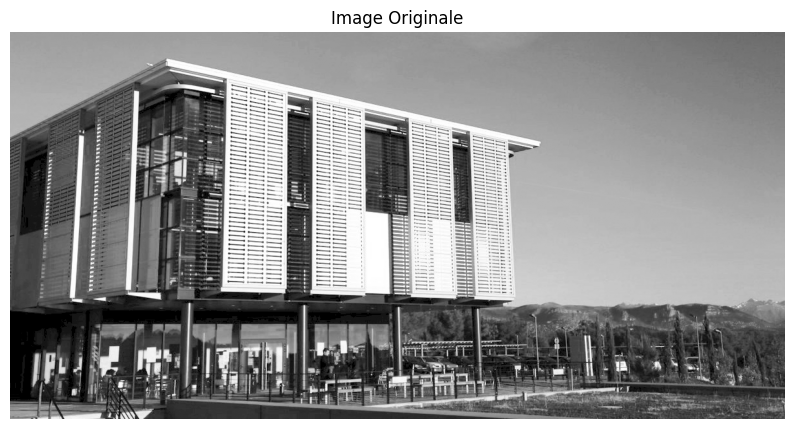

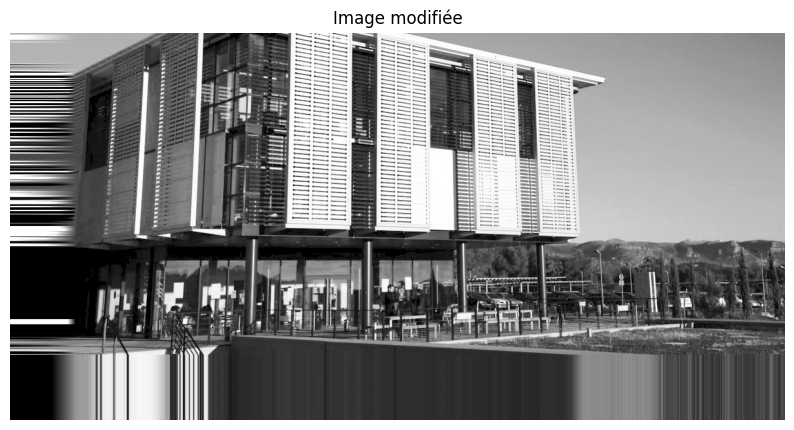

In [79]:
tx = 100
ty = -100
H = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0.0, 1]
])
test_homographie(img, H)

B. Le Scale

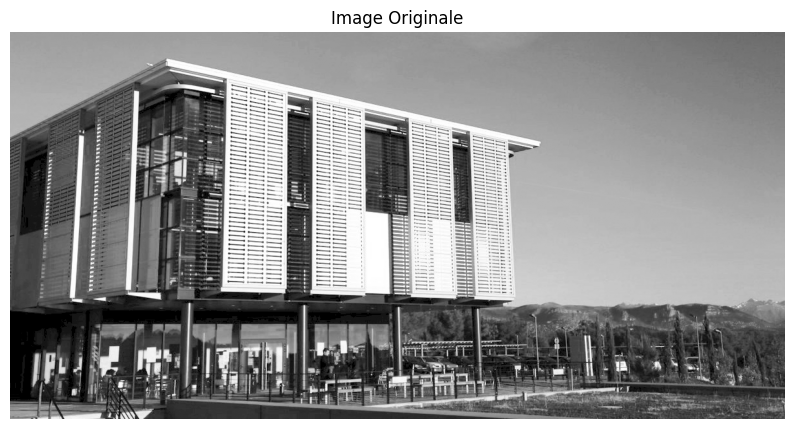

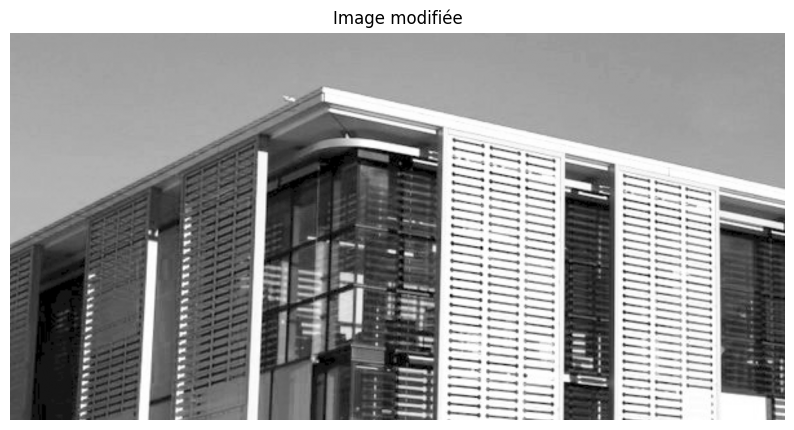

In [83]:
H = np.array([
    [2, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
])
test_homographie(img, H)

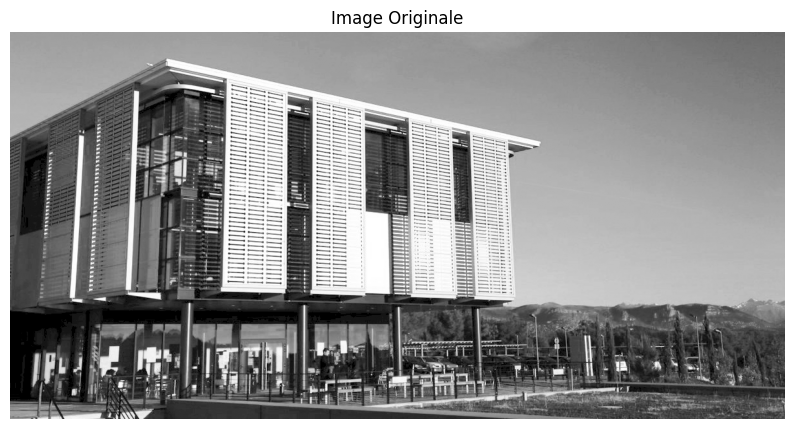

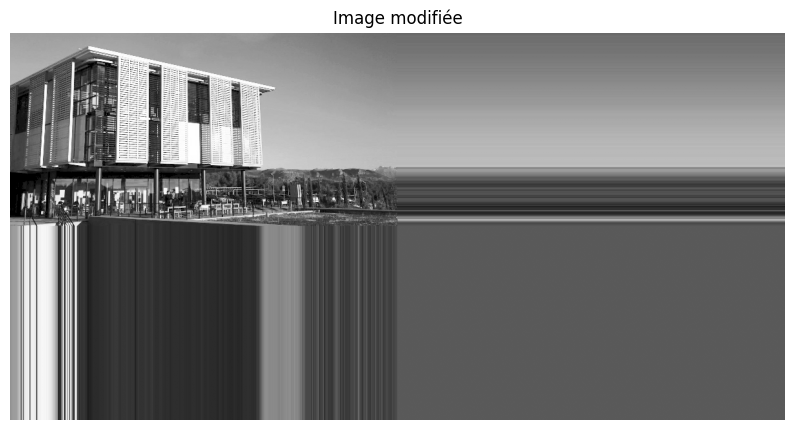

In [85]:
H = np.array([
    [0.5, 0, 0],
    [0, 0.5, 0],
    [0, 0, 1]
])
test_homographie(img, H)

On remarque ici que l'origine du repère est situé au point en haut à gauche. On peut donc viser une transformation de matrice pour modifier l'origine au centre de l'image.